# Trying Deep Learning models for MRI-based Water-fat separation
In this notebook, you can upload your own Chemical Shift-Encoded (CSE)-MR images and obtain the separated water-fat signals using the different DL-based models developed in this project. All of them were developed to work only with CSE-MR images obtained at **1.5T** scanners.

The accepted data formats to upload your data are:
* DICOM files
* MAT files - using the [ISMRM Water-Fat Toolbox](https://www.ismrm.org/workshops/FatWater12/data.htm) format

The available DL models for testing are:
* U-Net
* Multi-Decoder Water-Fat separation Network (MDWF-Net) - Refer to [DOI:10.1007/s00330-023-09576-2](https://doi.org/10.1007/s00330-023-09576-2)
* Variable Echo Times neural Network (VET-Net) - Refer to [DOI:10.1007/s00330-024-11164-x](https://doi.org/10.1007/s00330-024-11164-x)
* Artificial Intelligence-based Decomposition of water and fat with Echo asymmetry and Least squares estimation (AI-DEAL) - Soon to be published!

## Importing libraries

In [1]:
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_modality_lut

import numpy as np
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
import ipywidgets as widgets

from itertools import cycle
from time import process_time

Optionally, you can disable any available GPU. This is useful if your GPU's size is not enough to handle the data arrays.

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

Finally, we the customized libraries included in this repository are imported.

In [3]:
import tf2lib as tl
import DLlib as dl
import pylib as py
import wflib as wf
import data

## Loading CSE-MRI data
First, the dataset directory must be specified

In [4]:
# Dataset directory - Read DICOM files
# file_dir = "C:/Users/jpmen/Documents/FF-mat/2D_NSA1_ORIG_IM_0016/2D_NSA1_ORIG.mat"
file_dir = 'C:/Users/jpmen/OneDrive - Universidad Católica de Chile/Documents/MRI-Datasets/multi-echo/02538/CIB_CYBILL_MIRANDA/DICOM/2D_NSA1_ORIG_IM_0014/2D_NSA1_ORIG.mat'
# file_dir = "C:/Users/jpmen/OneDrive - Universidad Católica de Chile\Documents\MRI-Datasets\PDFF_Phantom_Data\datasets\site2_1p5T_protocol1.mat"

# Future output variables
F = list() # PDFF 
P = list() # FM 
R = list() # WF 
R2= list() # R2 

# Uncertainty variables
PDFF_vars = list()
WF_vars = list()
R2_vars = list()
FM_vars = list()

In the following block, you can choose the data format to be loaded. The default option is MAT files.

It should be noted that the array shape within DICOM files can vary according to the scanner in which MR data was acquired.

In [5]:
data_sel = widgets.Dropdown(
    options=['MAT','DICOM'],
    value='MAT',
    description='Data format:',
    disabled=False,
)
data_sel

Dropdown(description='Data format:', options=('MAT', 'DICOM'), value='MAT')

In [6]:
if data_sel.value == 'DICOM':
    ds = pydicom.dcmread(py.join(exp_dir,scan_fn))
    if X_aux is None:
        arr = ds.pixel_array #.transpose()
        X_aux = apply_modality_lut(arr, ds).astype(np.float32)
        X_aux = np.reshape(X_aux,(1,1,X_aux.shape[0],X_aux.shape[1],1))
        TE_aux = np.array([[np.float(ds.EchoTime) * 1e-3]]).astype(np.float32)
    else:
        arr = ds.pixel_array #.transpose()
        X_aux_2 = apply_modality_lut(arr, ds).astype(np.float32)
        X_aux_2 = np.reshape(X_aux_2,(1,1,X_aux_2.shape[0],X_aux_2.shape[1],1))
        TE_aux_2 = np.array([[np.float(ds.EchoTime) * 1e-3]]).astype(np.float32)
        X_aux = np.concatenate((X_aux,X_aux_2), axis=0)
        TE_aux = np.concatenate((TE_aux,TE_aux_2), axis=0)
elif data_sel.value == 'MAT':
    mat = sio.loadmat(file_dir)
    if 'imDataParams' in mat.keys():
        acq = mat['imDataParams'][0,0][0].astype('complex64')
        TE = mat['imDataParams'][0,0][1].astype('float32')
    elif 'imDataAll' in  mat.keys():
        acq = mat['imDataAll'][0,0][4].astype('complex64')
        TE = mat['imDataAll'][0,0][2].astype('float32') #0
    if acq.shape[0] % 16 != 0.0:
        acq = acq[:(acq.shape[0]-acq.shape[0]%16)]
    acq = np.transpose(acq, (2,4,0,1,3)) / np.max(np.abs(acq))
    acq_real = np.real(acq)
    acq_imag = np.imag(acq)
    X = np.concatenate((acq_real,acq_imag),axis=-1)
    X = np.flip(X,axis=0)
TE = np.expand_dims(TE,axis=-1)

In [7]:
# Build tensorflow dataset
TEs = tf.repeat(TE, [X.shape[0]], axis=0)
A_dataset = tf.data.Dataset.from_tensor_slices((X,TEs))
test_iter = cycle(A_dataset)

## Model Selection

In [8]:
model_sel = widgets.Dropdown(
    options=['U-Net', 'MDWF-Net', 'VET-Net','AI-DEAL'],
    value='AI-DEAL',
    description='Model:',
    disabled=False,
)
model_sel

Dropdown(description='Model:', index=3, options=('U-Net', 'MDWF-Net', 'VET-Net', 'AI-DEAL'), value='AI-DEAL')

The original training dataset had CSE-MRI data from 149 subjects. However, all the models have different versions that were trained using different ratios of real and synthetic data. In the following menu, you can choose the version that you want to use depending on the number of subjects whose (real) data that was used for training.

* *Disclaimer:* In the cases of U-Net and MDWF-Net, this option is only valid for 6-echo models; there is only a single 3-echo version for each of them and they were trained using real data only.

In [9]:
data_ratio_sel = widgets.Dropdown(
    options=[0,3,9,15,149],
    value=149,
    description='Real subjects considered for training:',
    disabled=False,
)
data_ratio_sel

Dropdown(description='Real subjects considered for training:', index=4, options=(0, 3, 9, 15, 149), value=149)

Additionally, you can also set the number of echoes to be considered as input. This parameter will change the imported version of U-Net and MDWF-Net models, while the remaining models will not depend on this value as they are able to handle different echo train lengths.

In [10]:
ech_sel = widgets.IntSlider(
    value=6,
    min=2,
    max=12,
    step=1,
    description='Num. Echoes:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
ech_sel

IntSlider(value=6, continuous_update=False, description='Num. Echoes:', max=12, min=2)

Lastly, for those models that use least squares to calculate water-fat signals after demodulating the CSE-MR signal, you can also choose to discard the first echo, since it has been demonstrated that its phase is usually corrupted (see [Hernando et al. (2012), *Addressing phase errors in fat‐water imaging using a mixed magnitude/complex fitting method*](https://onlinelibrary.wiley.com/doi/abs/10.1002/mrm.23044)).

In [11]:
remove_ech1 = widgets.Checkbox(
    value=False,
    description='Remove first echo',
)
remove_ech1

Checkbox(value=False, description='Remove first echo')

In [15]:
if model_sel.value == 'U-Net':
    if ech_sel.value == 6:
        if data_ratio_sel.value == 149:
            model_fn = 'Sup-202'
        elif data_ratio_sel.value == 15:
            model_fn = 'Sup-403'
        elif data_ratio_sel.value == 9:
            model_fn = 'Sup-402'
        elif data_ratio_sel.value == 3:
            model_fn = 'Sup-401'
        elif data_ratio_sel.value == 0:
            model_fn = 'Sup-400'
    elif ech_sel.value == 3:
        model_fn = 'Sup-203'
    experiment_dir = py.join('output',model_fn)
    args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))
    G_A2B = dl.UNet(input_shape=(None,None,2*ech_sel.value), n_out=2, filters=args.n_G_filters,output_activation='relu')
    checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints'))
elif model_sel.value == 'MDWF-Net':
    if ech_sel.value == 6:
        if data_ratio_sel.value == 149:
            model_fn = 'Sup-204'
        elif data_ratio_sel.value == 15:
            model_fn = 'Sup-404'
        elif data_ratio_sel.value == 9:
            model_fn = 'Sup-405'
        elif data_ratio_sel.value == 3:
            model_fn = 'Sup-406'
        elif data_ratio_sel.value == 0:
            model_fn = 'Sup-407'
    elif ech_sel.value == 3:
        model_fn = 'Sup-205'
    experiment_dir = py.join('output',model_fn)
    args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))
    G_A2B = dl.MDWF_Generator(input_shape=(None,None,2*ech_sel.value), filters=args.n_G_filters, 
                              WF_self_attention=args.D1_SelfAttention, R2_self_attention=args.D2_SelfAttention,
                              FM_self_attention=args.D3_SelfAttention)
    checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints'))
elif model_sel.value == 'VET-Net':
    if data_ratio_sel.value == 149:
        model_fn = 'TEaug-300'
    elif data_ratio_sel.value == 15:
        model_fn = 'TEaug-311'
    elif data_ratio_sel.value == 9:
        model_fn = 'TEaug-310'
    elif data_ratio_sel.value == 3:
        model_fn = 'TEaug-309'
    elif data_ratio_sel.value == 0:
        model_fn = 'TEaug-308'
    experiment_dir = py.join('output',model_fn)
    args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))
    G_A2B = dl.PM_Generator(input_shape=(None,None,None,2), te_input=True, te_shape=(None,), filters=args.n_G_filters)
    checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints'))
elif model_sel.value == 'AI-DEAL':
    experiment_dir = py.join('output','Unsup-110')
    args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))
    G_A2B = dl.UNet(input_shape=(None,None,None,2), bayesian=True, ME_layer=True, filters=args.n_G_filters,
                    self_attention=args.D1_SelfAttention)
    G_A2R2= dl.UNet(input_shape=(None,None,None,1), bayesian=True, ME_layer=True, filters=args.n_G_filters,
                    output_activation='sigmoid', self_attention=args.D2_SelfAttention)
    checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B, G_A2R2=G_A2R2), py.join(experiment_dir, 'checkpoints'))

try:  # restore checkpoint including the epoch counter
    checkpoint.restore().assert_existing_objects_matched()
except Exception as e:
    print(e)

In [16]:
# Sample function
@tf.function
def sample(A, TE):
    A_abs = tf.math.sqrt(tf.reduce_sum(tf.square(A), axis=-1, keepdims=True))
    A_msk = tf.reduce_mean(A_abs, axis=1, keepdims=True)
    A2B_msk = tf.concat([A_msk,A_msk], axis=-1)
    if A.shape[1] > ech_sel.value:
        A = A[:,:ech_sel.value,...]
    if model_sel.value == 'U-Net':
        A_pf = data.A_from_MEBCRN(A) # CHANGE TO NON-MEBCRN FORMAT
        A2B_WF_abs = G_A2B(A_pf, training=False)
        A2B_WF_abs = tf.expand_dims(A2B_WF_abs, axis=1)
        A2B_WF_abs = tf.transpose(A2B_WF_abs, perm=[0,4,2,3,1])
        A2B_WF = tf.concat([A2B_WF_abs, tf.zeros_like(A2B_WF_abs)], axis=-1)
        A2B = tf.concat([A2B_WF, tf.zeros_like(A2B_WF[:,:1,...])], axis=1)
        A2B = tf.where(A2B_msk>=5e-3, A2B, 0.0)
        A2B_var = None
    elif model_sel.value == 'MDWF-Net':
        A_pf = data.A_from_MEBCRN(A) # CHANGE TO NON-MEBCRN FORMAT
        A2B = G_A2B(A_pf, training=False)
        A2B = tf.expand_dims(A2B, axis=1)
        A2B_PM = A2B[...,-1:-3:-1]
        A2B_WF_abs = A2B[...,:2]
        A2B_WF_abs = tf.transpose(A2B_WF_abs, perm=[0,4,2,3,1])
        A2B_WF = tf.concat([A2B_WF_abs, tf.zeros_like(A2B_WF_abs)], axis=-1)
        A2B = tf.concat([A2B_WF, A2B_PM], axis=1)
        A2B = tf.where(A2B_msk>=5e-3, A2B, 0.0)
        A2B_var = None
    elif model_sel.value == 'VET-Net':
        A2B_PM = G_A2B([A,TE], training=False) #[:,:ech_sel.value,...]
        A2B_PM = tf.where(A2B_msk>=5e-3, A2B_PM, 0.0)
        if remove_ech1.value:
            A2B_WF = wf.get_rho(A[:,1:,...], A2B_PM, te=TE[:,1:,...])
        else:
            A2B_WF = wf.get_rho(A, A2B_PM, te=TE)
        A2B = tf.concat([A2B_WF, A2B_PM], axis=1)
        A2B_var = None
    elif model_sel.value == 'AI-DEAL':
        A2B_msk = tf.concat([A2B_msk,A2B_msk,A2B_msk], axis=1)
        A2B_var_msk = tf.concat([A2B_msk,A2B_msk,A2B_msk,A2B_msk,A2B_msk], axis=1)
        if remove_ech1.value:
            A2B_FM = G_A2B(A[:,1:,...], training=False)
        else:
            A2B_FM = G_A2B(A, training=False)
        A2B_R2 = G_A2R2(A_abs, training=False)
        A2B_PM = tf.concat([A2B_FM.mean(),A2B_R2.mean()],axis=-1)
        if remove_ech1.value:
            A2B_WF, A2B_WF_var = wf.PDFF_uncertainty(A[:,1:,...], A2B_FM, A2B_R2, te=TE[:,1:,...], rem_R2=False)
        else:
            A2B_WF, A2B_WF_var = wf.PDFF_uncertainty(A, A2B_FM, A2B_R2, te=TE, rem_R2=False)
        A2B_WF_var = tf.concat([A2B_WF_var,tf.zeros_like(A2B_WF_var)],axis=-1)
        A2B_PM_var = tf.concat([A2B_FM.variance(),A2B_R2.variance()],axis=-1)
        A2B_var = tf.concat([A2B_WF_var,A2B_PM_var], axis=1)
        if A.shape[1] >= A2B_var.shape[1]:
            A2B_var = tf.where(tf.abs(A[:,:5,...])>=5e-3, A2B_var, 1e-10)
        else:
            A_aux = tf.concat([A,A],axis=1)
            A2B_var = tf.where(A2B_msk>=5e-3, A2B_var, 1e-10)
        A2B = tf.concat([A2B_WF, A2B_PM], axis=1)
        A2B = tf.where(A2B_msk>=5e-3, A2B, 0.0)
    return A2B, A2B_var

def test(A, TE=None):
    A2B, A2B_var = sample(A, TE)
    return A2B, A2B_var

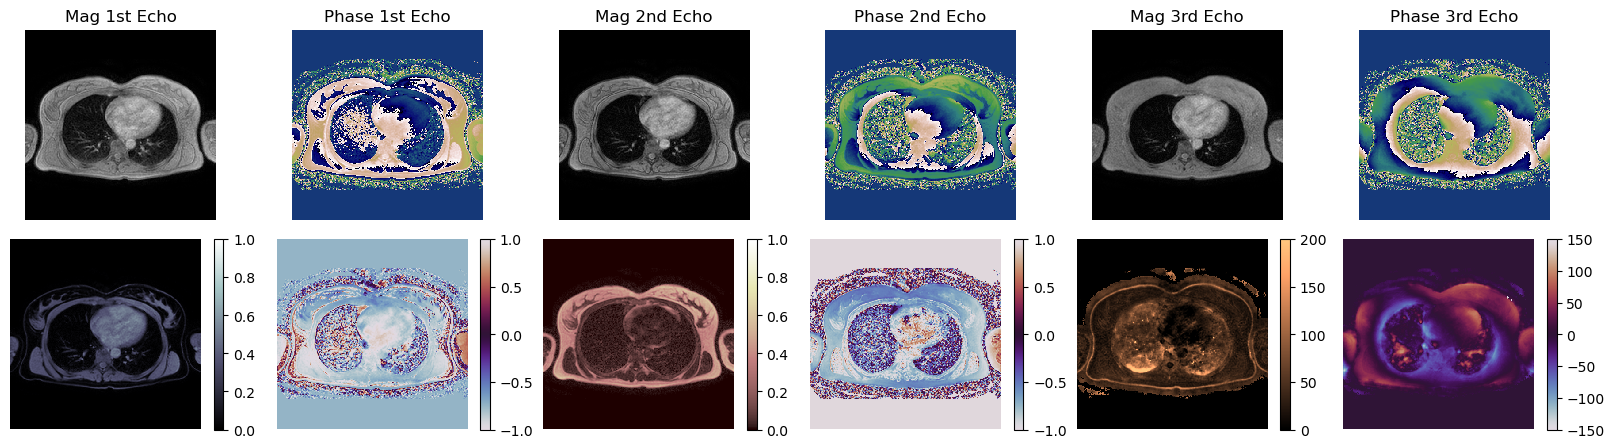

In [17]:
A, TE = next(test_iter)
A = tf.expand_dims(A,axis=0)
TE = tf.expand_dims(TE,axis=0)

fm_sc = 300.0
r2_sc = 200.0

A2B, A2B_var = test(A, TE)

fig, axs = plt.subplots(figsize=(16, 4), nrows=2, ncols=6)

# CSE-MR images at each echo
mag_ech1 = np.squeeze(np.abs(tf.complex(A[:,0,:,:,0],A[:,0,:,:,1])))
pha_ech1 = np.squeeze(np.arctan2(A[:,0,:,:,1],A[:,0,:,:,0]))
mag_ech2 = np.squeeze(np.abs(tf.complex(A[:,1,:,:,0],A[:,1,:,:,1])))
pha_ech2 = np.squeeze(np.arctan2(A[:,1,:,:,1],A[:,1,:,:,0]))
mag_ech3 = np.squeeze(np.abs(tf.complex(A[:,2,:,:,0],A[:,2,:,:,1])))
pha_ech3 = np.squeeze(np.arctan2(A[:,2,:,:,1],A[:,2,:,:,0]))

# Acquisitions in the first row
acq_ech1 = axs[0,0].imshow(mag_ech1, cmap='gray',
                      interpolation='none', vmin=0, vmax=1)
axs[0,0].set_title('Mag 1st Echo')
axs[0,0].axis('off')
acq_ech2 = axs[0,1].imshow(pha_ech1/np.pi, cmap='gist_earth',
                      interpolation='none', vmin=-1, vmax=1)
axs[0,1].set_title('Phase 1st Echo')
axs[0,1].axis('off')
acq_ech3 = axs[0,2].imshow(mag_ech2, cmap='gray',
                          interpolation='none', vmin=0, vmax=1)
axs[0,2].set_title('Mag 2nd Echo')
axs[0,2].axis('off')
acq_ech4 = axs[0,3].imshow(pha_ech2/np.pi, cmap='gist_earth',
                          interpolation='none', vmin=-1, vmax=1)
axs[0,3].set_title('Phase 2nd Echo')
axs[0,3].axis('off')
acq_ech5 = axs[0,4].imshow(mag_ech3, cmap='gray',
                          interpolation='none', vmin=0, vmax=1)
axs[0,4].set_title('Mag 3rd Echo')
axs[0,4].axis('off')
acq_ech6 = axs[0,5].imshow(pha_ech3/np.pi, cmap='gist_earth',
                          interpolation='none', vmin=-1, vmax=1)
axs[0,5].set_title('Phase 3rd Echo')
axs[0,5].axis('off')

# A2B maps in the second row
w_m_aux = np.squeeze(tf.abs(tf.complex(A2B[:,0,:,:,:1],A2B[:,0,:,:,1:])),axis=0)
w_p_aux = np.squeeze(tf.math.atan2(A2B[:,0,:,:,1],A2B[:,0,:,:,0]))
f_m_aux = np.squeeze(tf.abs(tf.complex(A2B[:,1,:,:,:1],A2B[:,1,:,:,1:])),axis=0)
f_p_aux = np.squeeze(tf.math.atan2(A2B[:,1,:,:,1],A2B[:,1,:,:,0]))
wf_m_aux = np.squeeze(tf.abs(tf.complex(A2B[:,0,:,:,:1]+A2B[:,1,:,:,:1],A2B[:,0,:,:,1:]+A2B[:,1,:,:,1:])),axis=0)
r2_aux = np.squeeze(A2B[:,2,:,:,1])
field_aux = np.squeeze(A2B[:,2,:,:,0])

PDFF_aux = np.where(f_m_aux >= w_m_aux, f_m_aux/wf_m_aux, 1-(w_m_aux/wf_m_aux))
PDFF_aux[np.isnan(PDFF_aux)] = 0.0    

W_ok =  axs[1,0].imshow(w_m_aux, cmap='bone',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_ok, ax=axs[1,0])
axs[1,0].axis('off')

Wp_ok =  axs[1,1].imshow(w_p_aux/np.pi, cmap='twilight',
                        interpolation='none', vmin=-1, vmax=1)
fig.colorbar(Wp_ok, ax=axs[1,1])
axs[1,1].axis('off')

F_ok =  axs[1,2].imshow(f_m_aux, cmap='pink',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_ok, ax=axs[1,2])
axs[1,2].axis('off')

Fp_ok =  axs[1,3].imshow(f_p_aux/np.pi, cmap='twilight',
                        interpolation='none', vmin=-1, vmax=1)
fig.colorbar(Fp_ok, ax=axs[1,3])
axs[1,3].axis('off')

r2_ok = axs[1,4].imshow(r2_aux*r2_sc, cmap='copper',
                        interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_ok, ax=axs[1,4])
axs[1,4].axis('off')

field_ok =  axs[1,5].imshow(field_aux*fm_sc, cmap='twilight',
                            interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_ok, ax=axs[1,5])
axs[1,5].axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
tl.make_space_above(axs,topmargin=0.8)
fig.set_facecolor("none")
plt.show()

# Update maps to be saved in MAT file
F.append(PDFF_aux*100.0)
P.append(np.expand_dims(field_aux*fm_sc, axis=-1))
R.append(np.expand_dims(np.concatenate([w_m_aux,f_m_aux],axis=-1), axis=-2))
R2.append(np.expand_dims(r2_aux*r2_sc, axis=-1))

In [ ]:
if A2B_var is not None:
    from matplotlib.colors import LogNorm

    W_var = np.squeeze(tf.abs(tf.complex(A2B_var[:,0,:,:,:1],A2B_var[:,0,:,:,1:])),axis=0)
    WF_var = np.squeeze(tf.abs(tf.complex(A2B_var[:,1,:,:,:1],A2B_var[:,1,:,:,1:])),axis=0)
    F_var = np.squeeze(tf.abs(tf.complex(A2B_var[:,3,:,:,:1],A2B_var[:,3,:,:,1:])),axis=0)
    r2s_var = np.squeeze(A2B_var[:,-1,:,:,1:],axis=0)*(r2_sc**2)
    field_var = np.squeeze(A2B_var[:,-1,:,:,:1],axis=0)*(fm_sc**2)

    PDFF_var = F_var/(f_m_aux**2 + 1e-8)
    PDFF_var -= 2 * WF_var / (f_m_aux*(w_m_aux+f_m_aux) + 1e-8)
    PDFF_var += (W_var + F_var + 2*WF_var)/(w_m_aux + f_m_aux + 1e-8)
    PDFF_var *= f_m_aux**2 / (w_m_aux+f_m_aux + 1e-4)**2 #[W_var,WF_var,F_var]
    PDFF_var[PDFF_var<=0.0] = 1e-2
    
    fig, axs = plt.subplots(figsize=(15, 4), nrows=2, ncols=5)

    # Estimated maps
    FF_ok = axs[0,0].imshow(PDFF_aux, cmap='jet',
                            interpolation='none', vmin=0, vmax=1)
    fig.colorbar(FF_ok, ax=axs[0,0])
    axs[0,0].axis('off')
    W_ok =  axs[0,1].imshow(w_m_aux, cmap='bone',
                            interpolation='none', vmin=0, vmax=1)
    fig.colorbar(W_ok, ax=axs[0,1])
    axs[0,1].axis('off')

    F_ok =  axs[0,2].imshow(f_m_aux, cmap='pink',
                            interpolation='none', vmin=0, vmax=1)
    fig.colorbar(F_ok, ax=axs[0,2])
    axs[0,2].axis('off')

    r2_ok = axs[0,3].imshow(r2_aux*r2_sc, cmap='copper',
                            interpolation='none', vmin=0, vmax=r2_sc)
    fig.colorbar(r2_ok, ax=axs[0,3])
    axs[0,3].axis('off')

    field_ok =  axs[0,4].imshow(field_aux*fm_sc, cmap='twilight',
                                interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
    fig.colorbar(field_ok, ax=axs[0,4])
    axs[0,4].axis('off')
    
    WF_uq = axs[1,0].matshow(PDFF_var, cmap='gnuplot2',
                            norm=LogNorm(vmin=1e-2,vmax=1e2))
    fig.colorbar(WF_uq, ax=axs[1,0])
    axs[1,0].axis('off')

    W_uq = axs[1,1].matshow(W_var, cmap='gnuplot2',
                            norm=LogNorm(vmin=1e-2,vmax=1e0))
    fig.colorbar(W_uq, ax=axs[1,1])
    axs[1,1].axis('off')

    F_uq = axs[1,2].matshow(F_var, cmap='gnuplot2',
                            norm=LogNorm(vmin=1e-2,vmax=1e0))
    fig.colorbar(F_uq, ax=axs[1,2])
    axs[1,2].axis('off')

    r2s_uq=axs[1,3].matshow(r2s_var, cmap='gnuplot',
                          norm=LogNorm(vmin=1e0,vmax=1e3))
    fig.colorbar(r2s_uq, ax=axs[1,3])
    axs[1,3].axis('off')

    field_uq = axs[1,4].matshow(field_var, cmap='gnuplot2',
                                norm=LogNorm(vmin=1e-5,vmax=1e-2))
    fig.colorbar(field_uq, ax=axs[1,4])
    axs[1,4].axis('off')

    # Update maps to be saved in MAT file
    PDFF_vars.append(PDFF_var*1e4)
    WF_vars.append(np.expand_dims(np.concatenate([W_var,WF_var,F_var],axis=-1), axis=-2))
    R2_vars.append(r2s_var)
    FM_vars.append(field_var)

In [ ]:
plt.matshow(PDFF_aux*100.0,cmap='jet',vmin=0.0,vmax=100.0)
# plt.matshow(PDFF_var, cmap='gnuplot2',norm=LogNorm(vmin=1e-2,vmax=1e2))
# plt.matshow(r2_aux*r2_sc, cmap='copper', vmin=0, vmax=r2_sc)
# plt.matshow(r2s_var, cmap='gnuplot', norm=LogNorm(vmin=1e0,vmax=1e3))
# plt.matshow(w_m_aux, cmap='bone', vmin=0, vmax=1)
# plt.matshow(f_m_aux, cmap='pink', vmin=0, vmax=1)
# plt.matshow(F_var, cmap='gnuplot2', norm=LogNorm(vmin=1e-2,vmax=1e0))
plt.axis('off')

In [ ]:
out_id = file_dir.split('/')[-2].split('_')[-1]
listdir = file_dir.split('/')[:-1]
listdir.append('res_MP_' + ''.join(model_sel.value.split('-')) + '_' + out_id + '.mat')
outpath = '/'.join(listdir)

outvars = {'F': np.concatenate(F,axis=-1),
           'P': np.concatenate(P,axis=-1),
           'R': np.concatenate(R,axis=-2),
           'R2':np.concatenate(R2,axis=-1),
           'mthd': model_sel.value}

if A2B_var is not None:
    var_outvars = {'F_var': np.concatenate(PDFF_vars, axis=-1),
                   'R_var': np.concatenate(WF_vars, axis=-2),
                   'R2_var': np.concatenate(R2_vars, axis=-1),
                   'P_var': np.concatenate(FM_vars, axis=-1)}
    outvars.update(var_outvars)

sio.savemat(outpath, outvars)